In [36]:
import sys
import io
from PIL import Image
from transformers import DetrImageProcessor, DetrForSegmentation
from diffusers import StableDiffusionXLInpaintPipeline
from transformers.models.detr.feature_extraction_detr import rgb_to_id
import torch
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def load_image(image_path):
    """
    Load an image from the specified path and convert it to RGB format.
    This function is useful for ensuring that the image is in a consistent format
    for further processing, such as inpainting or applying transformations.

    Args:
        image_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image in RGB format.
    """
    image = Image.open(image_path).convert("RGB")
    return image

In [34]:
def generate_mask_person(image):
    """
    Genera una máscara de persona/ropa usando un modelo de segmentación de Hugging Face.
    Args:
        image (PIL.Image.Image): Imagen de entrada.
    Returns:
        PIL.Image.Image: Máscara binaria (blanco: zona a modificar, negro: conservar).
    """


    # Cargar modelo y procesador
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50-panoptic")
    model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

    # Preprocesar imagen
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    #processed_sizes = [(inputs['pixel_values'].shape[-2], inputs['pixel_values'].shape[-1])]
    processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
    #result = processor.post_process_panoptic_segmentation(outputs, threshold=0.5, target_sizes=processed_sizes)[0]
    result = processor.post_process_panoptic(outputs, processed_sizes)[0]

    # Extraer máscara de persona (category_id == 0 para persona en COCO)
   # mask = np.zeros(result['segmentation'].shape, dtype=np.uint8)
   # for seg in result['segments_info']:
   #     if seg['category_id'] == 0:  # 0 es 'person' en COCO
   #         mask[result['segmentation'] == seg['id']] = 255
#
  # mask_img = Image.fromarray(mask).convert("L")
    panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
    panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
    # retrieve the ids corresponding to each mask
    mask_img = rgb_to_id(panoptic_seg)

    return mask_img

In [8]:
def apply_ip_adapter(image, reference_face_path=None):
    """
    Integra IP-Adapter para preservar el rostro usando una imagen de referencia.
    Args:
        image (PIL.Image.Image): Imagen de entrada.
        reference_face_path (str): Ruta a la imagen de referencia facial (opcional).
    Returns:
        dict: Diccionario con los argumentos necesarios para el pipeline de inpainting.
    """
    # Ejemplo de integración (requiere diffusers >=0.24 y el modelo IP-Adapter descargado)
    # Aquí solo preparamos los argumentos para el pipeline, la integración real se hace en el pipeline de inpainting.
    # Si tienes una imagen de referencia facial, la cargas aquí:
    reference_face = None
    if reference_face_path:
        reference_face = Image.open(reference_face_path).convert("RGB")
    # Devuelve la imagen original y la referencia facial para usarlas en el pipeline
    return {
        "image": image,
        "ip_adapter_image": reference_face
    }

In [9]:
def run_inpainting(image, mask, prompt, ip_adapter_image=None):
    """
    Run inpainting on the given image using the specified mask and prompt.

    Args:
        image (PIL.Image.Image): The input image to be inpainted.
        mask (PIL.Image.Image): The mask indicating the areas to be inpainted.
        prompt (str): The text prompt guiding the inpainting process.
        ip_adapter_image (PIL.Image.Image, optional): Reference image for IP-Adapter (face preservation).
    Returns:
        PIL.Image.Image: The inpainted image.
    """
    # Load the inpainting pipeline
    pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16"  # Use fp16 for better performance on GPUs
    ).to("cuda")

    # Integrate IP-Adapter if provided
    if ip_adapter_image is not None:
        pipe.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")
        result = pipe(
            prompt=prompt,
            image=image,
            mask_image=mask,
            ip_adapter_image=ip_adapter_image
        ).images[0]
    else:
        result = pipe(
            prompt=prompt,
            image=image,
            mask_image=mask
        ).images[0]

    return result

In [13]:
from google.colab import files
uploaded = files.upload()

from PIL  import Image
image = Image.open(next(iter(uploaded)))
image.show()

Saving istockphoto-494711330-612x612.jpg to istockphoto-494711330-612x612 (1).jpg


In [35]:
mask = generate_mask_person(image)
#mask.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

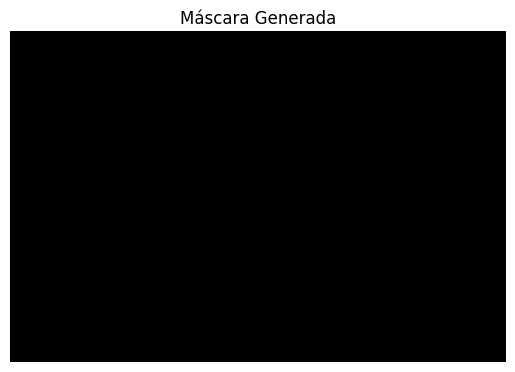

In [37]:
if isinstance(mask, np.ndarray):
    mask_img = Image.fromarray(mask)

# Mostrar la máscara usando Matplotlib
plt.imshow(mask_img, cmap="gray")
plt.title("Máscara Generada")
plt.axis("off")
plt.show()

In [ ]:
# Complete test
ip_adapter_args = apply_ip_adapter(image, reference_face_path=None)
ip_adapter_image = ip_adapter_args.get("ip_adapter_image", None)
result = run_inpainting(image, mask, "A professional portrait of a man in a suit", ip_adapter_image=ip_adapter_image)
result.show()